In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler


# This project is based on HVAS laboratories' Tutorial: https://www.youtube.com/watch?v=6f67zrH-_IE
# https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# In my version, both the weather.py and download.py fules were located in my Google Drive, this section may not be needed in your case

!cp /content/gdrive/MyDrive/Colab_Notebooks/Weather_Pred_Regression/weather.py . # Directory where the notebook and weather.py are kept on my Google Drive
!cp /content/gdrive/MyDrive/Colab_Notebooks/Weather_Pred_Regression/download.py .

In [ ]:
import weather # Since weather.py is stored in the GitHub page, we can directly import it

In [ ]:
weather.maybe_download_and_extract() # Downloading the dataset (around 35MB)

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [ ]:
# The dataset has the weather data of 5 Denmark cities

cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

In [ ]:
df = weather.load_resampled_data()  # load and resample the data for 60 minute intervals. Missing data-points are linearly interpolated.
df.head()

Aalborg               ...   Roskilde            
                         Temp     Pressure  ...  WindSpeed     WindDir
DateTime                                    ...                       
1980-03-01 11:00:00  5.000000  1007.766667  ...  11.466667  280.000000
1980-03-01 12:00:00  5.000000  1008.000000  ...  12.466667  280.000000
1980-03-01 13:00:00  5.000000  1008.066667  ...  13.133333  278.333333
1980-03-01 14:00:00  4.333333  1008.133333  ...  12.300000  270.000000
1980-03-01 15:00:00  4.000000  1008.200000  ...  12.300000  270.000000

[5 rows x 20 columns]

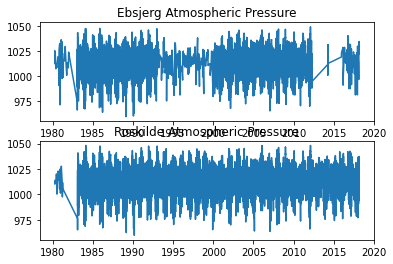

In [ ]:
# Since two cities (Esbjerg and Roskilde) have missing atmospheric pressure data, we will remove these columns from the data.
# It is worth noting that the tutorial did not remove the corresponding pressure data from other unaffected cities.
# It is also worth noting that the linear interpolation is trying to fill in the gaps in pressure data results in very inconsistent waveforms

fig, axs = plt.subplots(2)

axs[0].plot(df['Esbjerg']['Pressure'])
axs[0].set_title("Ebsjerg Atmospheric Pressure")

axs[1].plot(df['Roskilde']['Pressure'])
axs[1].set_title("Roskilde Atmospheric Pressure")

plt.axis('tight')
plt.show()

In [ ]:
# We remove the unwanted columns of data, so the total number of cols goes from 20 to 18
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)

df.values.shape
df.head()

Aalborg               ...   Roskilde            
                         Temp     Pressure  ...  WindSpeed     WindDir
DateTime                                    ...                       
1980-03-01 11:00:00  5.000000  1007.766667  ...  11.466667  280.000000
1980-03-01 12:00:00  5.000000  1008.000000  ...  12.466667  280.000000
1980-03-01 13:00:00  5.000000  1008.066667  ...  13.133333  278.333333
1980-03-01 14:00:00  4.333333  1008.133333  ...  12.300000  270.000000
1980-03-01 15:00:00  4.000000  1008.200000  ...  12.300000  270.000000

[5 rows x 18 columns]

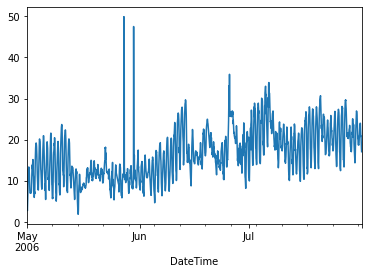

In [ ]:
# The provided data is not completely clean. The following shows an example of outlier data points which is impossible for Denmark.
# Ambient temperatures in Denmark would never reach 45 Degrees or more.
# We can also plot other cities in Denmark around this time period to check. Since they are geographically close together, they should have similar weather.

df['Odense']['Temp']['2006-05':'2006-07'].plot();

In [ ]:
# We can add more detail to our model by adding more data, based on what's already included in the original data files.

# This new data is the day (1-365) and the time of day (0-23). This information is already included in the dataset, but only as an index.
# The dataset now has more information which could be relevant for weather prediction. We assume that the time of day is equal across all cities.
# The addition of these two columns results in using 20 relevant data columns for the dataset.

df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour
df.head()

Aalborg                         ...    Roskilde Various     
                         Temp     Pressure WindSpeed  ...     WindDir     Day Hour
DateTime                                              ...                         
1980-03-01 11:00:00  5.000000  1007.766667      10.2  ...  280.000000      61   11
1980-03-01 12:00:00  5.000000  1008.000000      10.3  ...  280.000000      61   12
1980-03-01 13:00:00  5.000000  1008.066667       9.7  ...  278.333333      61   13
1980-03-01 14:00:00  4.333333  1008.133333      11.1  ...  270.000000      61   14
1980-03-01 15:00:00  4.000000  1008.200000      11.3  ...  270.000000      61   15

[5 rows x 20 columns]

In [ ]:
# It is now time to define the variables which we want to predict, and also the city that we want to focus on.
# The following will be the variables we want to predict: Temperature, Wind Speed and Pressure in Odense (town)
# The dataset already contained these data points, so our labels are taken care of.

target_city = 'Odense'
target_names = ['Temp', 'WindSpeed', 'Pressure']

In [ ]:
# We want to predict these variables over a 24 hour period. So we shift the data by 24 time steps (one per hour)

shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

# We create a new data frame with the time shifted area
df_targets = df[target_city][target_names].shift(-shift_steps) # The time shift is negative (future)

In [ ]:
# To view the predicted variable columns, you must select those specific columns
# This code allows us to see the first 24 rows of the original data-frame columns

df[target_city][target_names].head(shift_steps)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,6.142857,12.585714,1011.066667
1980-03-01 12:00:00,7.000000,11.300000,1011.200000
1980-03-01 13:00:00,7.000000,12.118182,1011.300000
1980-03-01 14:00:00,6.857143,12.742857,1011.400000
1980-03-01 15:00:00,6.000000,12.400000,1011.500000
1980-03-01 16:00:00,4.909091,12.618182,1011.688889
1980-03-01 17:00:00,3.953488,12.646512,1011.877778
1980-03-01 18:00:00,3.674419,11.725581,1012.066667
1980-03-01 19:00:00,3.395349,10.804651,1012.255556


In [ ]:
# We convert the pandas data-frames to numpy arrays
# We now create the input data values that will be fed to the neural network

x_data = df.values[0:-shift_steps]
num_data = len(x_data) # Number of observations/samples in dataset
print(type(x_data))
print("Shape:", x_data.shape)  # 20 columns and over 330 thousand samples

num_x_signals = x_data.shape[1]
num_x_signals

<class 'numpy.ndarray'>
Shape: (333085, 20)


20

In [ ]:
# We now create the label data values used in the neural network (same data but shifted by 24 hours)

y_data = df_targets.values[:-shift_steps]
num_y_signals = y_data.shape[1]
num_y_signals

3

In [ ]:
# We will define the percentage of the data values used for training
# We declare the number of samples used for training and testing

train_split = 0.8
num_train = int(train_split * num_data)
num_test = num_data - num_train

In [ ]:
# We declare the input arrays for training and test sets

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

len_x = len(x_train) + len(x_test)

In [ ]:
# We declare the labels for training and test sets

y_train = y_data[0:num_train]
y_test = y_data[num_train:]

len_y = len(y_train) + len(y_test)
len(y_train) + len(y_test)

333085

In [ ]:
# Original Tutorial Function to scale dataset (all values are between 0 and 1)

x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [ ]:
# We declare a function to create shorter subsequences picked at random from the training data, so that we do not have to use the 300k observations

def batch_generator(batch_size, sequence_length):
    
    #Generator function for creating random batches of training-data.

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [ ]:
# We will use a sequence-length of 1344, which means that each random sequence contains observations/samples for 8 weeks.
sequence_length = 24 * 7 * 8
sequence_length

# Each batch contains 256 sequences, a sequence is composed of 1344 observations/samples
batch_size = 256  

In [ ]:
# Create the batch generator
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

# We now test the batch generator to see if it works
# This gives us a random batch of 512 sequences, each sequence having 1344 observations, and each observation having 20 input-signals and 3 output-signals.
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 20)
(256, 1344, 3)


In [ ]:
# We need to ensure that our model does not overfit the data during the training process.
# For this reason, we monitor the test set performance on unseen data after each epoch (validation).
# In theory, using validation will ensure that the model weights are saved only if the performance is improved on the test set.

# In this case, the author chose to make the validation set the same as the test set.

validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [ ]:
# Creating the model
def build_RNN_model(num_x_signals, num_y_signals):

    model = keras.Sequential()

    # We include a singular GRU layer composed of 512 neurons
    # Input shape is a batch of sequences of arbitrary length (indicated by None), where each observation has a number of input-signals (num_x_signals)

    model.add(keras.layers.GRU(units=512, return_sequences=True, input_shape=(None, num_x_signals,)))

    # I chose to add an additional densely connected layer to see if it improves performance compared to the original tutorial
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # This is the output layer, where we will have 3 neurons representing each of the regression variables
    # The sigmoid activation function squashes the output to be between 0 and 1.
    model.add(keras.layers.Dense(num_y_signals, activation='sigmoid'))

    return model

In [ ]:
# Compiling the model

optimizer = keras.optimizers.RMSprop(lr=0.001)
mse = tf.keras.losses.MeanSquaredError()

model = build_RNN_model(num_x_signals, num_y_signals)

model.compile(loss=mse, optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         820224    
_________________________________________________________________
dense (Dense)                (None, None, 256)         131328    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 3)           771       
Total params: 952,323
Trainable params: 952,323
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Creating Checkpoints
# Checkpoints can be used for various purposes during training.

path_checkpoint = 'weather_prediction_checkpoint.keras'

# This callback writes checkpoints during training
callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                                      monitor='val_loss',
                                                      verbose=1,
                                                      save_weights_only=True,
                                                      save_best_only=True)

# This is the callback for stopping the optimization when performance worsens on the validation-set.
callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=5, verbose=1)

# This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by patience=0).
# Minimum learning rate is equal to: (initial learning rate x factor) = (0.001) x (0.1) = 0.0001

callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                      factor=0.1,
                                                      min_lr=1e-4,
                                                      patience=0,
                                                      verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]

In [ ]:
# These epochs are not the typical ones we normally use, because they are made from randomized batch generation (taken from anywhere in the dataset).
# Instead, we need to specify the steps per epoch during the training declaration.

EPOCHS = 10

# generator refers to the batch generator we used previously
# steps_per_epoch = The number of batches used in an EPOCH, we have to shorten it so we don't use the entire dataset in one EPOCH, to save time

history = model.fit(x=generator,
                    epochs=EPOCHS,
                    steps_per_epoch=25,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/10
25/25 [==============================] - 1209s 48s/step - loss: 0.0234 - accuracy: 0.7529 - val_loss: 0.0060 - val_accuracy: 0.9211

Epoch 00001: val_loss improved from inf to 0.00603, saving model to weather_prediction_checkpoint.keras
Epoch 2/10
25/25 [==============================] - 1096s 44s/step - loss: 0.0080 - accuracy: 0.8933 - val_loss: 0.0047 - val_accuracy: 0.9211

Epoch 00002: val_loss improved from 0.00603 to 0.00466, saving model to weather_prediction_checkpoint.keras
Epoch 3/10
25/25 [==============================] - 1094s 44s/step - loss: 0.0063 - accuracy: 0.8981 - val_loss: 0.0056 - val_accuracy: 0.9243

Epoch 00003: val_loss did not improve from 0.00466

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
25/25 [==============================] - 1097s 44s/step - loss: 0.0049 - accuracy: 0.9048 - val_loss: 0.0033 - val_accuracy: 0.9253

Epoch 00004: val_loss improved from 0.00466 to 0.00334, saving model to weather

In [ ]:
# We reload the last saved checkpoint, which should have the best performance on the test-set.

try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
SAVED_MODEL_Location = "/content/gdrive/MyDrive/assets/weather_prediction_model"

tf.saved_model.save(model, SAVED_MODEL_LOCATION)
weather_prediction_model = tf.keras.models.load_model(SAVED_MODEL_LOCATION)
weather_prediction_model.summary()

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/assets/weather_prediction_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/assets/weather_prediction_model/assets


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         820224    
_________________________________________________________________
dense (Dense)                (None, None, 256)         131328    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 3)           771       
Total params: 952,323
Trainable params: 952,323
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def plot_comparison(start_idx, length, train):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]

    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
               
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [ ]:
# We can now evaluate the model's performance on the test-set. This function originally expects a batch of data, instead we use the entire test set as a batch. 
# We just expand the array-dimensionality to create a batch with that one sequence.

result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 14s 14s/step - loss: 0.0029 - accuracy: 0.9242


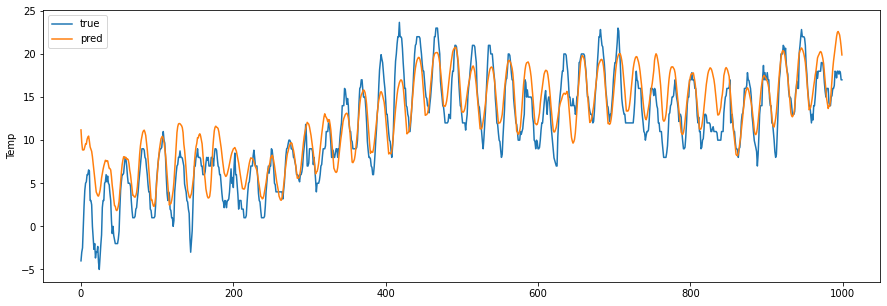

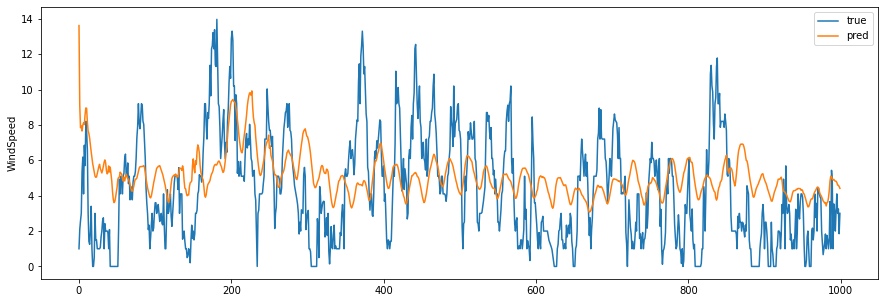

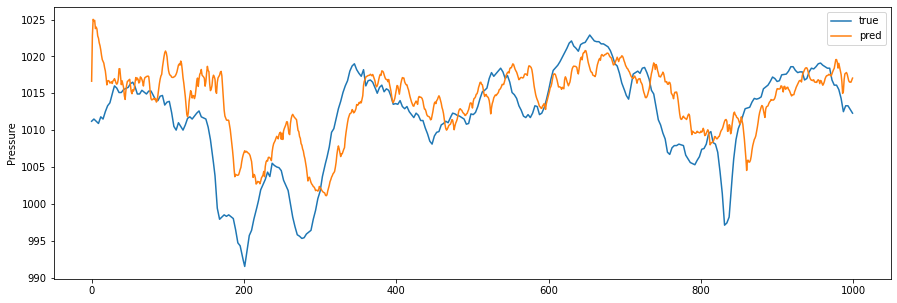

In [ ]:
# We now start plotting 1000 hours worth of predictions. These predictions use the Training set data.
# This is data that the model has seen during training so it should perform reasonably well.

plot_comparison(start_idx=10000, length=1000, train=True)

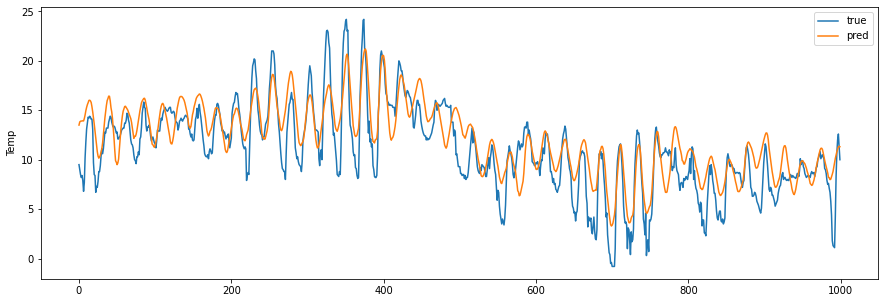

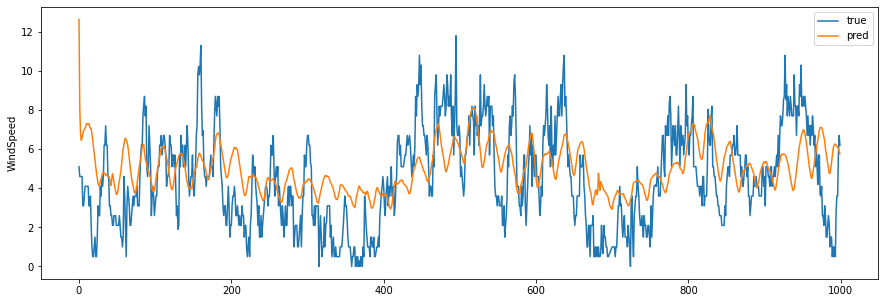

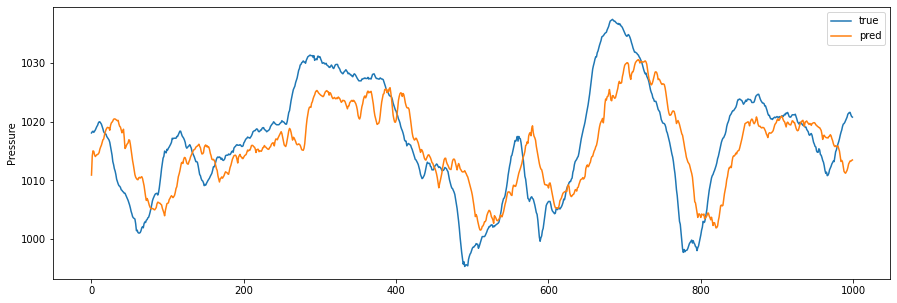

In [ ]:
# We now start plotting 1000 hours worth of predictions. These predictions use the Testing set data.
# The temperature is predicted reasonably well, given that it has not used the testing data yet, although the peaks are sometimes inaccurate.

plot_comparison(start_idx=10000, length=1000, train=False)